# 人工データの作成

In [1]:
import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # データ可視化ライブラリ
from sklearn.datasets import make_blobs
from lightning.pytorch import seed_everything
from sklearn.decomposition import PCA

plt.style.use("ggplot")
seed_everything(8)

Seed set to 8


8

In [59]:
N_DATA = 1000000  # データ数
N_CLUSTERS = 8  # クラスタ数
N_FEATURES = 10  # 特徴量数
RANDOM_STATE = 0  # 乱数シード
Y_SCALE = 1  # 目的変数の標準偏差
CLUSTER_STD = 1  # クラスタの標準偏差

# 人工データを生成
X, cluster_label = make_blobs(
    n_samples=N_DATA,
    centers=N_CLUSTERS,
    n_features=N_FEATURES,
    random_state=RANDOM_STATE,
    cluster_std=CLUSTER_STD,
)

# データの目的変数を N(cluster_label, Y_SCALE) に従うように生成
y = np.random.normal(cluster_label, Y_SCALE)

# # 各クラスタのデータ数が同じの為，適当にサンプリングしてばらつきを持たせる
# Xs = []
# cluster_labels = []
# ys = []
# for i in range(N_CLUSTERS):
#     idx = np.where(cluster_label == i)[0]
#     n_samples = np.random.randint(100, len(idx))  # クラスタごとにサンプリング数を変える
#     sample_idx = np.random.choice(idx, n_samples, replace=False)
#     Xs.append(X[sample_idx])
#     cluster_labels.append(cluster_label[sample_idx])
#     ys.append(y[sample_idx])

# X = np.concatenate(Xs)
# cluster_label = np.concatenate(cluster_labels)
# y = np.concatenate(ys)

## 生成したデータの分布を確認

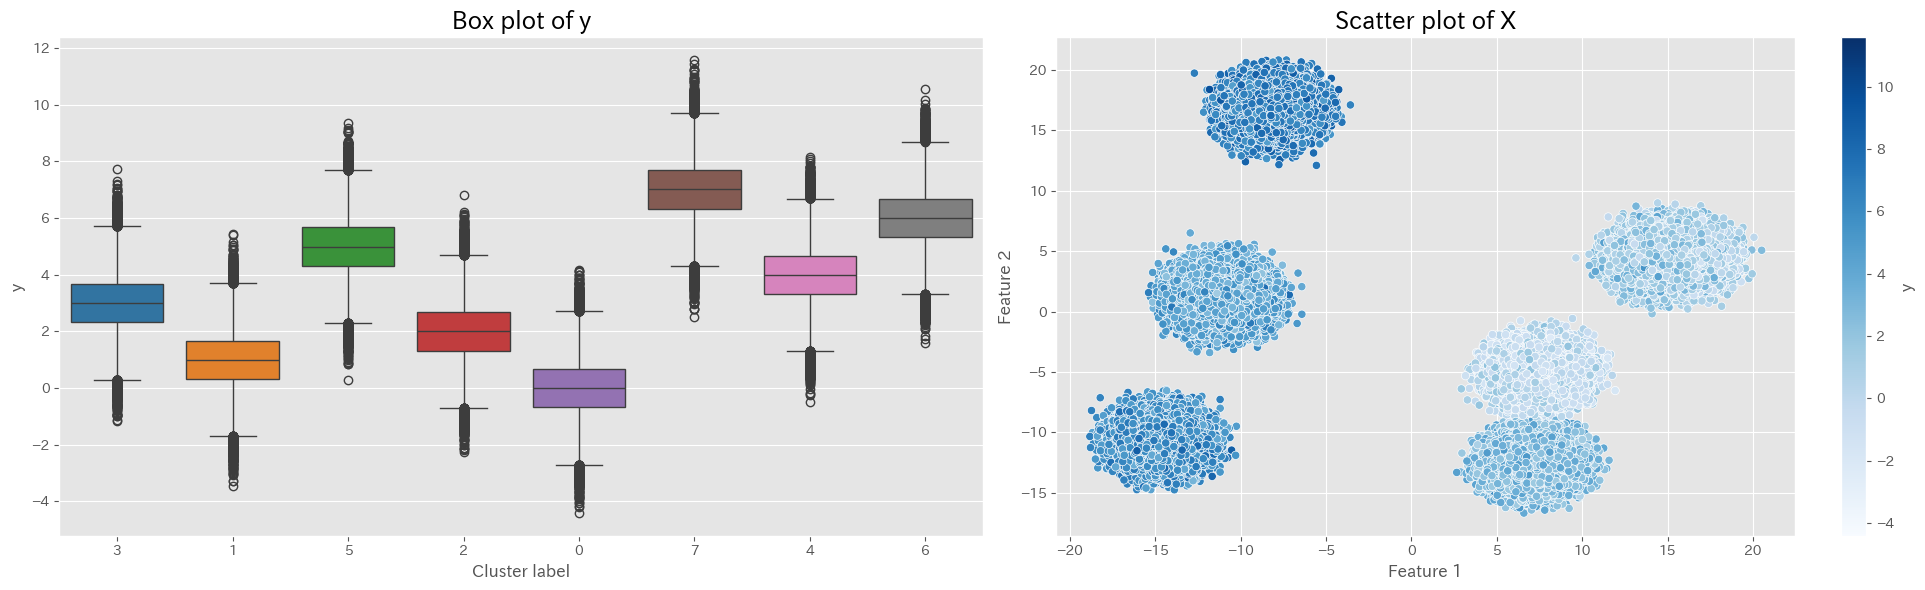

In [60]:
# 目的変数の分布
axes: list[plt.Axes]
fig, axes = plt.subplots(
    1, 2, figsize=(10 * 2, 6 * 1)
)  # 1行2列のサブプロット（横幅20, 縦幅6）
sns.boxplot(  # 箱ひげ図
    x=cluster_label.astype(str),  # x軸、as.type(str)で文字列に変換
    y=y,  # y軸
    ax=axes[0],  # グラフを描画するサブプロット指定
    hue=cluster_label.astype(str),  # クラスタラベルに基づいて色を付ける
    palette="tab10",  # カラーパレット指定
    legend=False,
)
axes[0].set_title("Box plot of y", fontdict={"fontsize": "xx-large"})
axes[0].set_xlabel("Cluster label")
axes[0].set_ylabel("y")

# データの散布図
## 次元削減
pca = PCA(n_components=2)  # 主成分分析で2次元に削減
X_pca = pca.fit_transform(X)  # XにPCAを適用
# 散布図（x軸：第1主成分、y軸：第2主成分、色分けのためにyを指定、サブプロット、色パレット、凡例）
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=y, ax=axes[1], palette="Blues", legend=False
)
axes[1].set_title("Scatter plot of X", fontdict={"fontsize": "xx-large"})
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")
## colorbar（右のバー）
# カラーバーを作成するためのオブジェクト作成（カラーマップ指定、yの最小値から最大値を正規化）
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=y.min(), vmax=y.max()))
sm._A = []  # smの内部のデータをクリア
cbar = fig.colorbar(sm, ax=axes[1])
cbar.set_label("y")

fig.tight_layout()

基底クラス

In [61]:
from abc import ABCMeta, abstractmethod

from numpy.typing import NDArray
from sklearn.cluster import KMeans


class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(サンプル数), H(クラスタ数)）
    def __init__(self, n_samples: int, H: int, random_state: int):
        self.n_samples = n_samples
        self.H = H
        self.random_state = random_state

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        """クラスタリングを行う

        Args:
            X (NDArray): データ (N x M)

        Returns:
            NDArray: クラスタラベル (N, ), クラスタサイズ (H, )

        Note:
            N: データ数
            M: 特徴量数
            H: クラスタ数
        """
        # kmeans:KMeansを用いてself.H個のクラスタに分割する
        kmeans = KMeans(n_clusters=self.H, random_state=self.random_state)
        # XをKMeansを用いてself.H個のクラスタに分割し、各データのクラスタラベル取得
        cluster_label = kmeans.fit_predict(X)
        # 母集団の各クラスタのサイズを計算
        _, cluster_size = np.unique(cluster_label, return_counts=True)
        # インスタンス変数として設定
        self.cluster_label = cluster_label
        self.N = cluster_size
        return cluster_label, cluster_size.copy()

Random allocation

In [62]:
from numpy.typing import NDArray


# BaseAllocationを継承することでBaseAllocationクラスで定義されたインスタンス変数やメゾッドを利用できる
class RandomAllocation(BaseAllocation):
    # 抽象メゾッドを具象化
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.n_samples])

        return n  # （例）標本サイズが100のとき、n=[100]

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        # cluster_labelのすべての要素は0（すべてのデータを同じクラスタに属させている）
        cluster_label = np.zeros(X.shape[0])
        # クラスタサイズ＝データ数
        cluster_size = np.array([len(cluster_label)])
        return cluster_label, cluster_size


## 最適標本配分
Binary SearchもしくはCapacity scaling またはSimple Greedy [1]で各クラスタのサンプル数を決定

[1]: Ulf Friedrich, Ralf Münnich, Sven de Vries, Matthias Wagner, 2015. Fast
   integer-valued algorithms for optimal allocations under constraints in stratified
   sampling. Computational Statistics and Data Analysis 92(2015) 1-12.

In [63]:
def lower_median(data):
    # データをソート
    sorted_data = sorted(data)
    l = len(sorted_data)
    # データの数が偶数の場合
    if l % 2 == 0:
        lower_median_value = sorted_data[l // 2 - 1]
    else:
        lower_median_value = sorted_data[l // 2]
    return lower_median_value

In [64]:
from typing import Literal, Optional

from numpy.typing import NDArray


class OptimalAllocation(BaseAllocation):
    def __init__(
        self,
        n_samples: int,
        H: int,
        m: NDArray,  # 標本数下限
        M: Optional[NDArray] = None,  # 標本数上限
        method: Literal["binary", "capacity scaling", "greedy"] = "greedy",
        random_state: int = 0,
    ):
        super().__init__(
            n_samples, H, random_state
        )  # 基底クラスBaseAllocationの初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本数 (H, )
        self.M = M  # 各クラスタの最大標本数 (H, ), (指定しない場合はクラスタサイズ)
        self.method = method

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        d = (self.N**2) * S  # (H, )

        if self.method == "binary":
            n = self._binary_search(d=d)
        elif self.method == "capacity scaling":
            n = self._capacity_scaling(n=self.m.copy(), d=d)
        elif self.method == "greedy":
            n = self._simple_greedy(n=self.m.copy(), d=d)
        else:
            raise ValueError(f"Invalid method: {self.method}")

        # 制約チェック
        self._check_constraints(n)

        return n

    def _binary_search(self, d: NDArray) -> NDArray:
        I = np.arange(self.H)  # noqa # クラスタのインデックスを表す配列 (H, )
        n = self.m.copy()  # 各クラスタの最小標本数でnを初期化 (H, )
        u_old = self.m.copy()  # 各クラスタの最小標本数で初期化(H, )
        m = self.m.copy()  # 各クラスタの最小標本数 (H, )
        M = (
            self.M.copy() if self.M is not None else self.N.copy()
        )  # クラスタサイズ (H, ), (指定しない場合はクラスタサイズ)

        while n.sum() != self.n_samples:
            u = u_old.copy()
            delta = np.zeros(self.H)
            u[I] = np.floor((M + m) / 2)[I]
            delta[I] = (d / u - d / (u - 1))[I]

            if not np.all(u == u_old):
                s = lower_median(delta)  # noqa
            else:
                if (M - m + 1)[I].max() == 2:
                    n = self._simple_greedy(n, d)
                    return n

                h_star = np.argmax((M - m + 1)[I])
                s = delta[I][h_star]

            n[I] = np.floor(0.5 + np.sqrt(0.25 - d * (s ** (-1))))[I]
            n[I] = np.maximum(n, m)[I]  # if n_h < m_h, n_h <- m_h
            n[I] = np.minimum(n, M)[I]  # if n_h > M_h, n_h <- M_h

            if n.sum() < self.n_samples:
                m = n.copy()
            else:
                M = n.copy()

            # m == MのindexをIから削除
            I_ = I.tolist()
            I_ = [i for i in I_ if m[i] != M[i]]
            I = np.array(I_)  # noqa
            print(I)
            u_old = u.copy()

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()  # クラスタサイズ上限
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n.sum() != self.n_samples) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _capacity_scaling(self, n: NDArray, d: NDArray) -> NDArray:
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        m = self.m.copy()
        M = self.M.copy() if self.M is not None else self.N.copy()  # クラスタサイズ上限
        s = np.floor(self.n_samples / (2 * self.H))
        while s > 1:
            while (n.sum() < self.n_samples) and len(I) != 0:
                delta = np.zeros(self.H)
                delta[I] = (d / (n + 1) - d / n)[I]
                h_star = np.argmin(delta[I])
                h_star = I[h_star]

                if n[h_star] + 1 <= M[h_star]:
                    if n[h_star] + s <= M[h_star]:
                        n[h_star] = n[h_star] + s
                    else:
                        n[h_star] = n[h_star] + 1
                        I_ = I.tolist()
                        I_ = [i for i in I_ if i != h_star]
                        I = np.array(I_)  # noqa
                else:
                    I_ = I.tolist()
                    I_ = [i for i in I_ if i != h_star]
                    I = np.array(I_)  # noqa
            I = np.arange(self.H)  # noqa
            for h in I:
                n[h] = max(n[h] - s, m[h])
            s = np.floor(s / 2)
        n = self._simple_greedy(n, d)

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.n_samples
        ), f"Total sample size is over than {self.n_samples}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"

# 比較実験

In [65]:
import numpy as np
from numpy.typing import NDArray


def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        y_cluster = y[cluster_label == h]
        # クラスタ内でランダム n_h サンプリング
        sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]

    return y_hat

In [72]:
N_SAMPLES = 10000  # 標本数
H = 10  # クラスタ数
N_TRIALS = 100  # 試行回数
m_VALUE = 2  # 各クラスタの最小標本数
import time

# 戦略を定義
policies: list[BaseAllocation] = [
    OptimalAllocation(
        n_samples=N_SAMPLES,
        H=H,
        random_state=RANDOM_STATE,
        m=np.full(H, m_VALUE),
        M=None,
        method="greedy",  # binary or greedy
    ),
    OptimalAllocation(
        n_samples=N_SAMPLES,
        H=H,
        random_state=RANDOM_STATE,
        m=np.full(H, m_VALUE),
        M=None,
        method="capacity scaling",  # binary or greedy
    ),
    #    OptimalAllocation(
    #        n_samples=N_SAMPLES,
    #        H=H,
    #        random_state=RANDOM_STATE,
    #        m=np.full(H, m_VALUE),
    #        M=None,
    #        method="binary",  # binary or greedy
    #    ),
]

cluster_label_list = []
time_list = []
for policy in policies:
    start_time = time.time()
    cluster_label, _ = policy.clustering(X)
    end_time = time.time()
    elapsed_time = end_time - start_time
    cluster_label_list.append(cluster_label)
    time_list.append(elapsed_time)
# それぞれの戦略で各クラスタの標本数を求解
allocations: list[dict] = []  # 各戦略の実行結果が辞書形式で追加される
allocations.append(
    {
        "policy": "単純貪欲",
        "n": policies[0].solve(X, y),
        "cluster_label": cluster_label_list[0],
    }
)
allocations.append(
    {
        "policy": "容量スケーリング",
        "n": policies[1].solve(X, y),
        "cluster_label": cluster_label_list[1],
    }
)
# allocations.append(
#    {
#        "policy": "二分探索",
#        "n": policies[2].solve(X, y),
#        "cluster_label": cluster_label_list[2],
#    }
# )

# for policy in policies:
# policyを用いてXをクラスタリング(_は戻り値の２番目を無視)
#    cluster_label, _ = policy.clustering(X)
#    n = policy.solve(X, y)
#    allocations.append(
#        {
#            "policy": policy.__class__.__name__,
#            "n": n,
#            "cluster_label": cluster_label,
#        }
#    )

# 各戦略の標本数に基づいて目的変数の平均を推定
y_hats = []
for random_state in range(N_TRIALS):
    for allocation in allocations:
        y_hat = estimate_y_mean(allocation["n"], allocation["cluster_label"], y)
        y_hats.append(
            {
                "policy": allocation["policy"],
                "y_hat": y_hat,
                "random_state": random_state,
            }
        )

{'単純貪欲': 0.0001246806400299003, '容量スケーリング': 0.00011622031419771507}
単純貪欲 [1251 1250  623 1250 1248  602 1248 1252  648  628]
容量スケーリング [1251 1250  623 1250 1248  602 1248 1252  648  628]
[0.869469404220581, 0.8614249229431152]


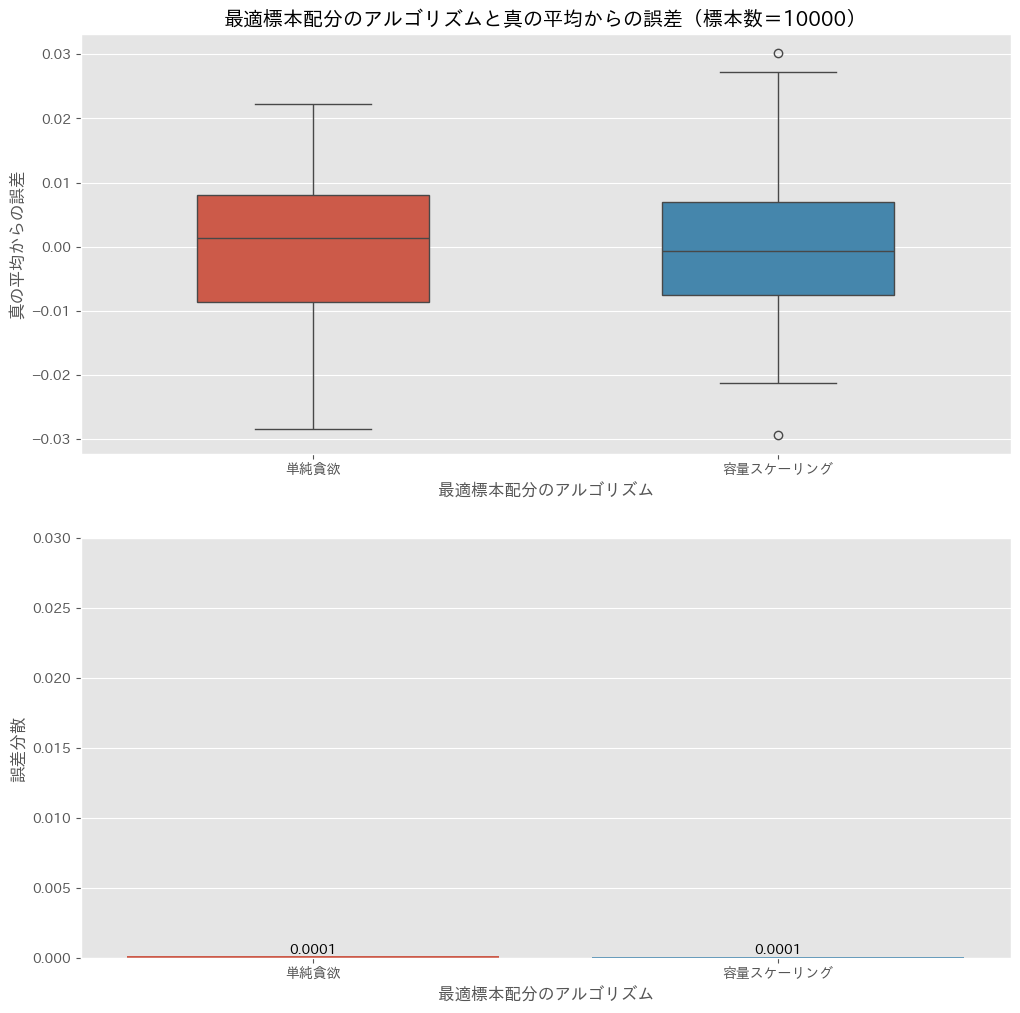

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

axes: list[plt.Axes]
fig, axes = plt.subplots(2, 1, figsize=(12, 6 * 2))

# 箱ひげ図で誤差の分布を比較
y_hat_df = pd.DataFrame(y_hats)
y_hat_df["error"] = (
    y_hat_df["y_hat"] - y.mean()
)  # 真の平均からの誤差をerrorカラムに追加
sns.boxplot(
    data=y_hat_df,
    y="error",
    x="policy",
    hue="policy",
    ax=axes[0],
    linewidth=1,
    width=0.5,
)
axes[0].set_title(
    "最適標本配分のアルゴリズムと真の平均からの誤差（標本数＝{}）".format(N_SAMPLES)
)
axes[0].set_ylabel("真の平均からの誤差")
axes[0].set_xlabel("最適標本配分のアルゴリズム")

# 棒グラフでRandomAllocationに対する誤差分散削減率を比較
# random_allocation以外の誤差分散
vardict = {}
vardict["単純貪欲"] = y_hat_df[y_hat_df["policy"] == "単純貪欲"]["error"].var()
vardict["容量スケーリング"] = y_hat_df[y_hat_df["policy"] == "容量スケーリング"][
    "error"
].var()
print(vardict)

## policyの順番をpoliciesの順番に調整
# reduction_rate = reduction_rate.reindex(
#    [policy.__class__.__name__ for policy in policies]
# )
keys = []
values = []
for key, value in vardict.items():
    keys.append(key)
    values.append(value)

sns.barplot(
    x=keys,
    y=values,
    ax=axes[1],
    hue=keys,
)
# 棒グラフの上に値を表示
for key, value in vardict.items():
    axes[1].text(key, value, f"{value:.4f}", ha="center", va="bottom")

axes[1].set_ylabel("誤差分散")
axes[1].set_xlabel("最適標本配分のアルゴリズム")
axes[1].set_ylim(0, 0.03)

print("単純貪欲", allocations[0]["n"])
print("容量スケーリング", allocations[1]["n"])
print(time_list)